In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import torchvision
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [12]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [13]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [14]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [9]:
import torch.nn.functional as F
#dropout_value = 0.0
class Net(nn.Module):
    def __init__(self,norm_type="BN",n_groups=0,dropout_value=0.05):
        super(Net,self).__init__()
        self.norm_type=norm_type
        self.n_groups=n_groups
        self.dropout_value=dropout_value
    
        print("HI")
        #self.normalization_type = normalization_type
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(), 
            self.normalize(8),
            
            nn.Dropout(dropout_value)
        ) # output_size = 8

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            self.normalize(10),
            nn.Dropout(dropout_value)
        ) # output_size = 10

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 12
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),  
            self.normalize(14),         
            nn.Dropout(dropout_value)
        ) # output_size = 14
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            self.normalize(16),
            nn.Dropout(dropout_value)
        ) # output_size = 16
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),        
            self.normalize(16),
            
            nn.Dropout(dropout_value)
        ) # output_size = 16
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=18, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            self.normalize(18),
            
            nn.Dropout(dropout_value)
        ) # output_size = 18
        
          
        # OUTPUT BLOCK
        self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=6)) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)) 


        self.dropout = nn.Dropout(dropout_value)
    
    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        #x = self.convblock8(x)
        #x = self.convblock9(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)
        
    def normalize(self,ch_out):
        if self.norm_type=="BN" :
            return nn.BatchNorm2d(ch_out)
        elif (self.norm_type=="GN") or (self.norm_type=="LN"):
            return nn.GroupNorm(self.n_groups,ch_out)  
        else:
            print("Please Enter a valid Normalization type(BN/GN/LN)") 

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from torchvision import datasets,transforms
import matplotlib.pyplot as plt

In [10]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
HI
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             720
              ReLU-6           [-1, 10, 24, 24]               0
       BatchNorm2d-7           [-1, 10, 24, 24]              20
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 12, 24, 24]             120
        MaxPool2d-10           [-1, 12, 12, 12]               0
           Conv2d-11           [-1, 14, 10, 10]           1,512
             ReLU-12           [-1, 14, 10, 10]               0
      BatchNorm2d-13           [-1, 14, 10, 10]              28
          Dropout-14           

In [16]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
x_epoch = []
fig = plt.figure()
ax0 = fig.add_subplot(121, title="Loss")
ax1 = fig.add_subplot(122, title="Accuracy")

In [ ]:
import torch
import numpy as np
import pandas as pd
seed=42
import os
#from model import Net
import seaborn as sns
torch.manual_seed(seed)
from model import Net
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau
from typing import Union,List
import argparse
import numpy as np
from torchvision import datasets,transforms
import matplotlib.pyplot as plt
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau
seed=42
torch.manual_seed(seed)

In [17]:
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau
from typing import Union,List
import argparse

parser= argparse.ArgumentParser(description="Digit Classifier")
parser.add_argument("-n","--norm_type",default="BN",type=str,help="Enter 'BN' for Batch norm 'LN' for layer norm and 'GN' for Group Norm")
parser.add_argument("-E","--EPOCHS",default=20,type=int)
parser.add_argument("-ng","--n_groups",default=0,type=int,help="no of groups you want for group normalization.Pass 1 if using layer norm")
parser.add_argument("-dv","--dropout_value",default=0.05,type=float,help="dropout value")
args= parser.parse_args()

usage: ipykernel_launcher.py [-h] [-n NORM_TYPE] [-E EPOCHS] [-ng N_GROUPS]
                             [-dv DROPOUT_VALUE]
ipykernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-5b57a5ec-fc37-4254-8d90-0f81b6f9a72a.json


SystemExit: 2

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3560: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [18]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

HI
EPOCH: 0


Loss=0.13832402229309082 Batch_id=468 Accuracy=88.31: 100%|██████████| 469/469 [00:18<00:00, 25.44it/s]



Test set: Average loss: 0.0672, Accuracy: 9831/10000 (98.31%)

EPOCH: 1


Loss=0.059348780661821365 Batch_id=468 Accuracy=97.62: 100%|██████████| 469/469 [00:18<00:00, 25.72it/s]



Test set: Average loss: 0.0492, Accuracy: 9876/10000 (98.76%)

EPOCH: 2


Loss=0.10793628543615341 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:18<00:00, 25.28it/s] 



Test set: Average loss: 0.0335, Accuracy: 9902/10000 (99.02%)

EPOCH: 3


Loss=0.010660371743142605 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:17<00:00, 27.23it/s]



Test set: Average loss: 0.0307, Accuracy: 9905/10000 (99.05%)

EPOCH: 4


Loss=0.05695447325706482 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:17<00:00, 26.28it/s] 



Test set: Average loss: 0.0269, Accuracy: 9924/10000 (99.24%)

EPOCH: 5


Loss=0.08926767110824585 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:17<00:00, 26.92it/s] 



Test set: Average loss: 0.0260, Accuracy: 9913/10000 (99.13%)

EPOCH: 6


Loss=0.014361470006406307 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:18<00:00, 25.31it/s] 



Test set: Average loss: 0.0216, Accuracy: 9934/10000 (99.34%)

EPOCH: 7


Loss=0.16445250809192657 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:18<00:00, 25.41it/s] 



Test set: Average loss: 0.0323, Accuracy: 9900/10000 (99.00%)

EPOCH: 8


Loss=0.013126295059919357 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:17<00:00, 26.45it/s] 



Test set: Average loss: 0.0239, Accuracy: 9934/10000 (99.34%)

EPOCH: 9


Loss=0.08856207877397537 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:18<00:00, 25.76it/s]  



Test set: Average loss: 0.0223, Accuracy: 9930/10000 (99.30%)

EPOCH: 10


Loss=0.04996175691485405 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:18<00:00, 25.96it/s]  



Test set: Average loss: 0.0237, Accuracy: 9923/10000 (99.23%)

EPOCH: 11


Loss=0.014875431545078754 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:17<00:00, 26.87it/s] 



Test set: Average loss: 0.0222, Accuracy: 9927/10000 (99.27%)

EPOCH: 12


Loss=0.006119556725025177 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:18<00:00, 25.72it/s] 



Test set: Average loss: 0.0198, Accuracy: 9937/10000 (99.37%)

EPOCH: 13


Loss=0.04279203340411186 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:17<00:00, 26.08it/s]  



Test set: Average loss: 0.0239, Accuracy: 9923/10000 (99.23%)

EPOCH: 14


Loss=0.04442982003092766 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:18<00:00, 25.61it/s]  



Test set: Average loss: 0.0188, Accuracy: 9936/10000 (99.36%)



usage: ipykernel_launcher.py [-h] [-n NORM_TYPE] [-E EPOCHS] [-ng N_GROUPS]
                             [-dv DROPOUT_VALUE]
ipykernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-5b57a5ec-fc37-4254-8d90-0f81b6f9a72a.json


SystemExit: 2

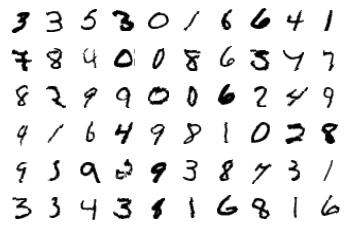

In [20]:
images,labels= next(iter(train_loader))
num_of_images=60
for index in range(1,num_of_images+1):
  plt.subplot(6, 10, index)
  plt.axis('off')
  plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

from torchsummary import summary
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau
from typing import Union,List
import argparse

parser= argparse.ArgumentParser(description="Digit Classifier")
parser.add_argument("-n","--norm_type",default="BN",type=str,help="Enter 'BN' for Batch norm 'LN' for layer norm and 'GN' for Group Norm")
parser.add_argument("-E","--EPOCHS",default=20,type=int)
parser.add_argument("-ng","--n_groups",default=0,type=int,help="no of groups you want for group normalization.Pass 1 if using layer norm")
parser.add_argument("-dv","--dropout_value",default=0.05,type=float,help="dropout value")
args= parser.parse_args()

In [21]:
def plot(epochs,**kargs):    
    ax0.plot(epochs, losses['train'], 'bo-', label='train loss')
    ax0.plot(epochs, losses['val'], 'ro-', label='val loss')
    ax1.plot(epochs, accuracy['train'], 'bo-', label='train accuracy')
    ax1.plot(epochs, accuracy['val'], 'ro-', label='val accuracy')
    if epochs[0] == 0:
        ax0.legend()
        ax1.legend()
    fig.savefig(os.path.join('./LossGraphs', 'train.jpg'))

In [22]:
if __name__=="__main__":
  
  model=Net(args.norm_type,args.n_groups,args.dropout_value).to(device)
  optim_adam=optim.Adam(model.parameters(),lr=2.15E-02)
  scheduler= ReduceLROnPlateau(optim_adam,threshold=0.0001,patience=1,factor=.215,mode='max')
  summary(model,input_size=(1,28,28))
 
  losses, accuracy={},{}
  losses["train"]=[]
  losses["val"]=[]
  accuracy["train"]=[]
  accuracy["val"]=[]
  for epoch in range(args.EPOCHS):
    print(f"EPOCH {epoch}")
    train_epoch_loss,train_epoch_accuracy = train(train_loader,model,optim_adam)
    val_epoch_loss,val_epoch_accuracy = test(test_loader,model,optim_adam)

    scheduler.step(val_epoch_accuracy)
    losses["train"].append(train_epoch_loss)
    accuracy["train"].append(train_epoch_accuracy)

    losses["val"].append(val_epoch_loss)
    accuracy["val"].append(val_epoch_accuracy)
  print(len(losses["train"]))
  plot(range(args.EPOCHS),losses=losses,accuracy=accuracy)  

NameError: name 'args' is not defined

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Instantiate the model
b_model = Net(normalization='batch').to(device)
l_model = Net(normalization='layer').to(device)
g_model = Net(normalization='group').to(device)

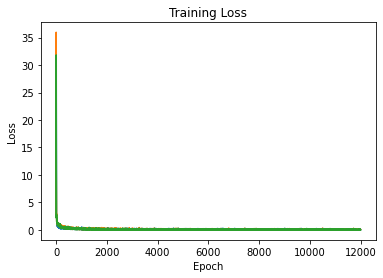

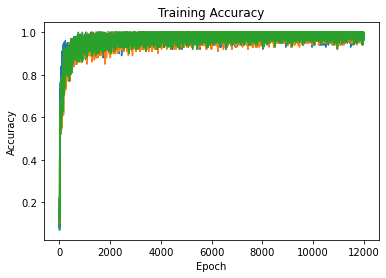

In [6]:
import matplotlib.pyplot as plt

# Plot the training loss
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot the training accuracy
plt.plot(train_accuracy)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

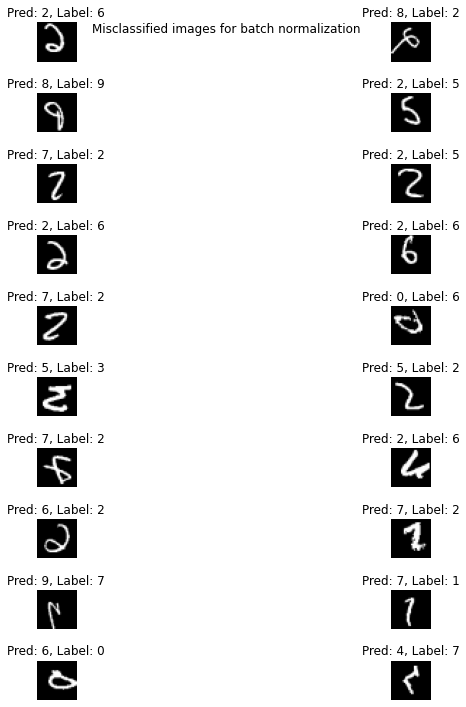

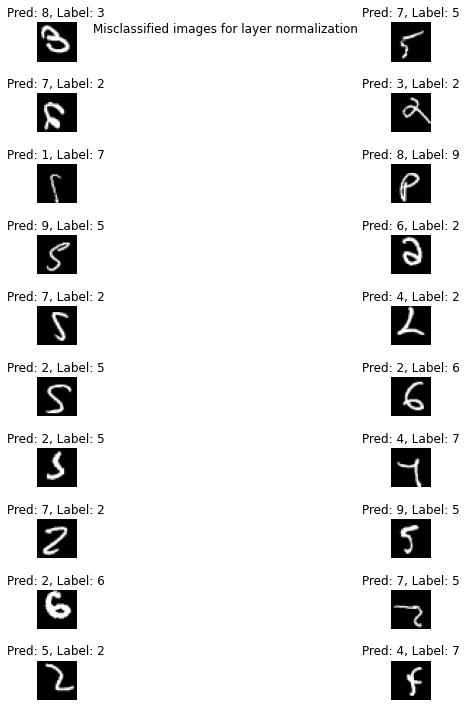

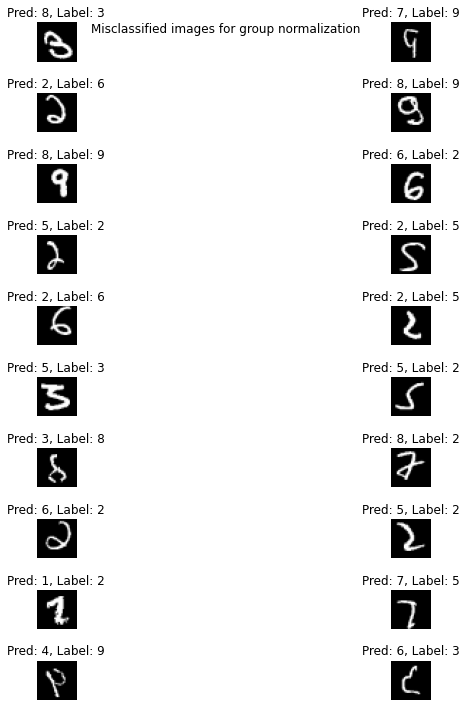

In [7]:
# Load the test dataset
test_dataset = MNIST(root='./data', 
                                train=False, 
                                transform=transform)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               batch_size=batch_size, 
                                               shuffle=False)

# Initialize the misclassified images array
norms = {'batch':b_model,'layer':l_model,'group':g_model}
misclassified_images = []
num_images = 20

# Predict the test set
for norm,model in norms.items():
    misclassified_images = []
    with torch.no_grad():
      for images, labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          # Append the misclassified images to the array
          for i in range(len(predicted)):
              if predicted[i] != labels[i]:
                  misclassified_images.append((images[i], predicted[i], labels[i]))
                  if len(misclassified_images) == num_images:
                      break
          if len(misclassified_images) == num_images:
              break

  # Plot the misclassified images
    fig, axs = plt.subplots(10, 2, figsize=(10, 10))
    fig.tight_layout()
    axs = axs.ravel()
    for i, (image, pred, label) in enumerate(misclassified_images):
        axs[i].imshow(image.cpu().numpy().squeeze(), cmap='gray')
        axs[i].set_title(f'Pred: {pred}, Label: {label}')
        axs[i].axis('off')

    plt.suptitle(f'Misclassified images for {norm} normalization')
    plt.show()